In [1]:
import sys
sys.path.append('core')

import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

DEVICE = 'cuda'

In [2]:
from decord import VideoReader
import matplotlib.pyplot as plt

In [3]:
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)

def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    plt.imshow(img_flo / 255.0)
    plt.show()

def demo(args):
    model = torch.nn.DataParallel(RAFT(args))
    model.load_state_dict(torch.load(args.model))

    model = model.module
    model.to(DEVICE)
    model.eval()

    with torch.no_grad():
        images = glob.glob(os.path.join(args.path, '*.png')) + \
                 glob.glob(os.path.join(args.path, '*.jpg'))
        
        images = sorted(images)
        for imfile1, imfile2 in zip(images[:-1], images[1:]):
            image1 = load_image(imfile1)
            image2 = load_image(imfile2)

            padder = InputPadder(image1.shape)
            image1, image2 = padder.pad(image1, image2)
            
            flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
            viz(image1, flow_up)
            viz(image2, flow_low)

/home/martin/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


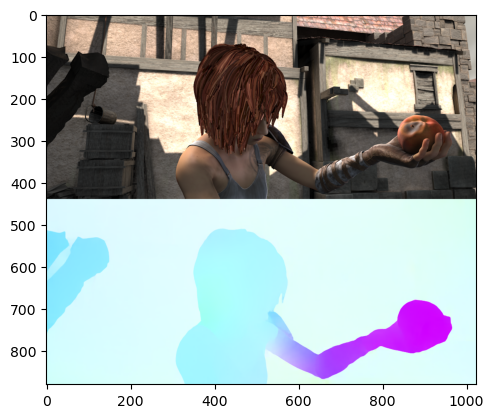

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1024 and the array at index 1 has size 128

In [4]:
from argparse import Namespace

args = Namespace(model='models/raft-things.pth', 
                 path='demo-frames', 
                 small=False, 
                 mixed_precision=False, 
                 alternate_corr=False)

# Run the demo function
demo(args)

In [5]:
def list_mp4_files(directory_path):
    mp4_files = []
    
    # Check if the directory exists
    if not os.path.isdir(directory_path):
        raise NotADirectoryError(f"The directory {directory_path} does not exist.")
    
    # Iterate through the files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".mp4"):
            full_path = os.path.join(directory_path, filename)
            mp4_files.append(full_path)
    
    return mp4_files

directory_path = os.path.expanduser("~/Documents/MAIA/data/")
mp4_files = list_mp4_files(directory_path)

print(mp4_files)

['/home/martin/Documents/MAIA/data/5daf8b58-08fb-4335-98df-17d29928b1be.mp4', '/home/martin/Documents/MAIA/data/5f1a80d7-8ebb-4768-bcd1-551eb20b6b60.mp4', '/home/martin/Documents/MAIA/data/8bf12e4a-bc8d-4f14-a33d-cf427224d446.mp4', '/home/martin/Documents/MAIA/data/18174010-ac51-49c6-96ed-693c89190f56.mp4', '/home/martin/Documents/MAIA/data/12116dba-4735-4d0c-b0be-c12b76bacc88.mp4', '/home/martin/Documents/MAIA/data/bb39c05c-5ae1-478c-9a9e-3458364d7488.mp4']


In [6]:
def video_info(video_file):
    # Create a VideoReader object
    vr = VideoReader(video_file)
    
    # Get the number of frames
    num_frames = len(vr)
    
    # Get the video resolution
    width, height = vr.get_batch([0]).shape[2], vr.get_batch([0]).shape[1]
    
    return num_frames, width, height

for video_file in mp4_files:
    num_frames, width, height = video_info(video_file)
    print(f"Video file: {video_file}")
    print(f"Number of frames: {num_frames}")
    print(f"Resolution: {width} x {height}")
    print("----------")

Video file: /home/martin/Documents/MAIA/data/5daf8b58-08fb-4335-98df-17d29928b1be.mp4
Number of frames: 5036
Resolution: 1400 x 1080
----------
Video file: /home/martin/Documents/MAIA/data/5f1a80d7-8ebb-4768-bcd1-551eb20b6b60.mp4
Number of frames: 293
Resolution: 1400 x 1080
----------
Video file: /home/martin/Documents/MAIA/data/8bf12e4a-bc8d-4f14-a33d-cf427224d446.mp4
Number of frames: 495
Resolution: 720 x 576
----------
Video file: /home/martin/Documents/MAIA/data/18174010-ac51-49c6-96ed-693c89190f56.mp4
Number of frames: 1141
Resolution: 1216 x 1072
----------
Video file: /home/martin/Documents/MAIA/data/12116dba-4735-4d0c-b0be-c12b76bacc88.mp4
Number of frames: 2058
Resolution: 720 x 576
----------
Video file: /home/martin/Documents/MAIA/data/bb39c05c-5ae1-478c-9a9e-3458364d7488.mp4
Number of frames: 3418
Resolution: 720 x 576
----------


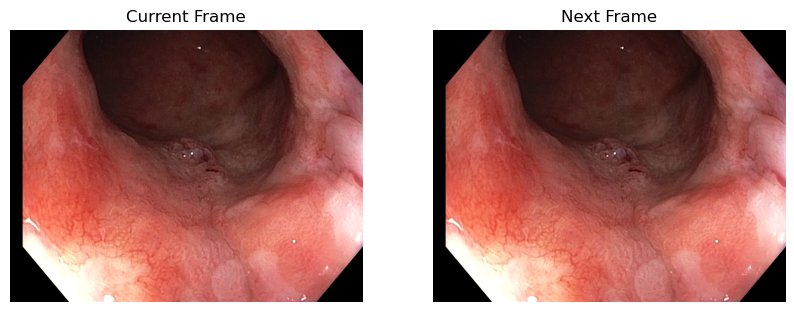

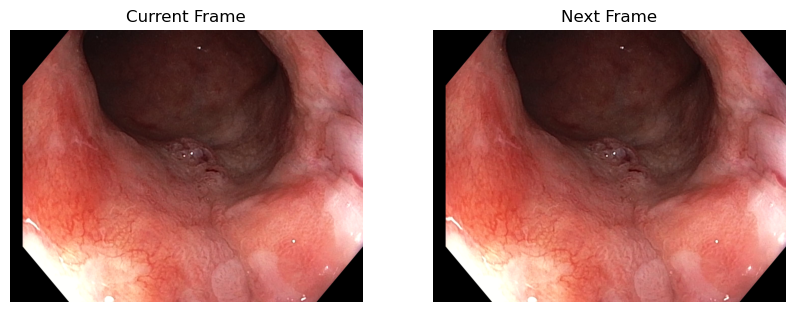

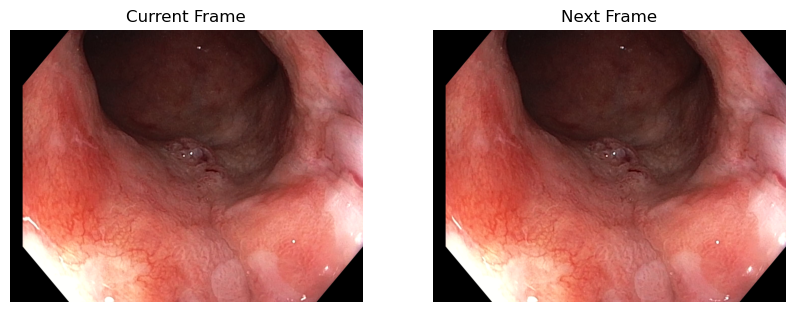

In [7]:
def plot_frame_pairs(video_file):
    vr = VideoReader(video_file)
    num_frames = len(vr)
    
    for i in range(3):#range(num_frames - 1):
        # Get the current and next frames
        current_frame = vr[i].asnumpy()
        next_frame = vr[i + 1].asnumpy()
        
        # Create a new figure
        plt.figure(figsize=(10, 5))
        
        # Plot current frame
        plt.subplot(1, 2, 1)
        plt.imshow(current_frame)
        plt.title('Current Frame')
        plt.axis('off')
        
        # Plot next frame
        plt.subplot(1, 2, 2)
        plt.imshow(next_frame)
        plt.title('Next Frame')
        plt.axis('off')
        
        # Show the plot
        plt.show()

# Replace 'your_video_file.mp4' with the path to your video file
video_file = mp4_files[0]
plot_frame_pairs(video_file)

In [8]:
vr = VideoReader(video_file)
num_frames = len(vr)

i=0
# Get the current and next frames
current_frame = vr[i].asnumpy()
next_frame = vr[i + 1].asnumpy()

# Convert from RGB to BGR format (as required by OpenCV)
current_frame_bgr = cv2.cvtColor(current_frame, cv2.COLOR_RGB2BGR)
next_frame_bgr = cv2.cvtColor(next_frame, cv2.COLOR_RGB2BGR)

# Save the frames as JPEG images
cv2.imwrite('cur.jpg', current_frame_bgr)
cv2.imwrite('next.jpg', next_frame_bgr)

True

In [10]:
from argparse import Namespace

args = Namespace(model='models/raft-things.pth', 
                 path='demo-frames', 
                 small=False, 
                 mixed_precision=False, 
                 alternate_corr=False)

model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model = model.module
model.to(DEVICE)
model.eval()

torch.set_grad_enabled(False)

In [19]:
def compute_optical_flow(imfile1, imfile2):
    image1 = load_image(imfile1)
    image2 = load_image(imfile2)

    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)

    flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
    flo = flow_up[0].permute(1, 2, 0).cpu().numpy()

    return flo

imfile1, imfile2 = 'cur.jpg', 'next.jpg'
flo = compute_optical_flow(imfile1, imfile2)

flo.shape

(1080, 1400, 2)

In [38]:
def preprocess_flow(flo):
    # Get the dimensions of the flow
    height, width, _ = flo.shape
    
    # Calculate the coordinates for cropping to the central square
    if width > height:
        left = (width - height) // 2
        right = left + height
        top = 0
        bottom = height
    else:
        top = (height - width) // 2
        bottom = top + width
        left = 0
        right = width
    
    # Crop to the central square
    flo_cropped = flo[top:bottom, left:right]
    
    # Resize to 512x512
    flo_resized = cv2.resize(flo_cropped, (512, 512))
    
    return flo_resized

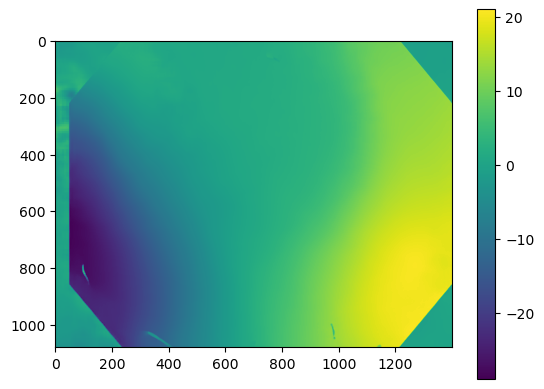

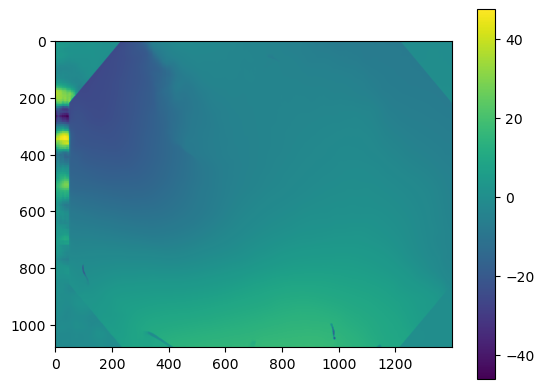

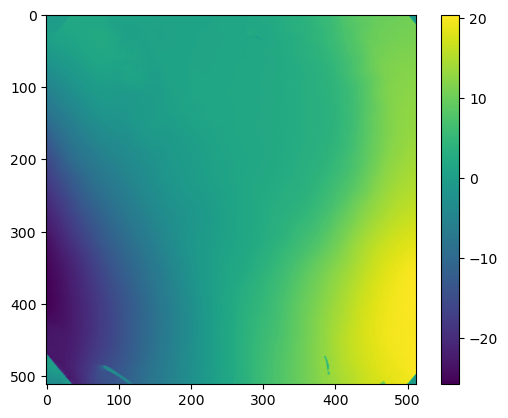

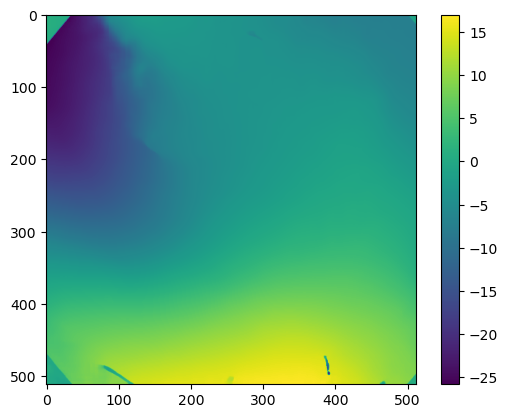

In [42]:
plt.imshow(flo[:,:,0])#, vmin=0, vmax=1
plt.colorbar()
plt.show()
plt.imshow(flo[:,:,1])#, vmin=0, vmax=1
plt.colorbar()
plt.show()

flo2 = preprocess_flow(flo)

plt.imshow(flo2[:,:,0])#, vmin=0, vmax=1
plt.colorbar()
plt.show()
plt.imshow(flo2[:,:,1])#, vmin=0, vmax=1
plt.colorbar()
plt.show()

In [43]:
from tqdm.notebook import tqdm

def optical_flow_on_video(video_file):
    vr = VideoReader(video_file)
    num_frames = len(vr)
    
    # Get the dimensions of the first frame
    first_frame = vr[0].asnumpy()
    height, width, _ = first_frame.shape
    
    # Initialize the array to hold all optical flows
    all_flows = np.empty((num_frames - 1, 512, 512, 2), dtype=np.float16)
    
    for i in tqdm(range(num_frames - 1), desc='Computing Optical Flow'):
        # Get the current and next frames
        current_frame = vr[i].asnumpy()
        next_frame = vr[i + 1].asnumpy()
        
        # Convert from RGB to BGR format (as required by OpenCV)
        current_frame_bgr = cv2.cvtColor(current_frame, cv2.COLOR_RGB2BGR)
        next_frame_bgr = cv2.cvtColor(next_frame, cv2.COLOR_RGB2BGR)

        # Save the frames as JPEG images
        cv2.imwrite('cur.jpg', current_frame_bgr)
        cv2.imwrite('next.jpg', next_frame_bgr)
        
        # Compute optical flow
        flo = compute_optical_flow('cur.jpg', 'next.jpg')
        
        #crop and rescale
        flo = preprocess_flow(flo)
        
        # Store the optical flow
        all_flows[i] = flo

    return all_flows

# Call the function with the path to your video file
flows = optical_flow_on_video(mp4_files[1])
print('Optical flows shape:', flows.shape)

Computing Optical Flow:   0%|          | 0/292 [00:00<?, ?it/s]

Optical flows shape: (292, 512, 512, 2)


In [ ]:
for video_file in mp4_files:
    # Run optical_flow_on_video function
    flows = optical_flow_on_video(video_file)
    
    # Construct the output file path
    output_file_path = os.path.join(os.path.dirname(video_file), os.path.basename(video_file).replace('.mp4', '.npy'))
    
    # Save the flow array to disk
    np.save(output_file_path, flows)
    print(f'Optical flows saved to {output_file_path}')

Computing Optical Flow:   0%|          | 0/5035 [00:00<?, ?it/s]